In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import time
from PIL import Image # For loading single images
from tqdm import tqdm # For progress bar
import matplotlib.pyplot as plt

In [2]:
# --- 0. Configuration and Setup ---

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Recommended for reproducibility

In [4]:
# Directories
data_dir = "images"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
model_save_dir = "models"
os.makedirs(model_save_dir, exist_ok=True) # Create models directory if it doesn't exist

In [5]:
# Emotion classes (ensure this matches your folder names)
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(classes)

In [17]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-5 # Or even 5e-6. Experiment with this!
NUM_EPOCHS = 30 # You can increase this if needed, but 15 is a good start with transfer learning

In [18]:
# --- 1. Data Transformations ---

# ImageNet normalization values (standard for models pre-trained on ImageNet)
# If your grayscale images are replicated to 3 channels, these are the appropriate means/stds
# for a model pre-trained on RGB images.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [19]:
# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3-channel RGB
    transforms.Resize((224, 224)),              # Resize for MobileNetV3 input
    transforms.RandomHorizontalFlip(),          # Data augmentation
    transforms.ToTensor(),                      # Convert PIL image to PyTorch Tensor
    transforms.Normalize(mean, std)             # Normalize pixel values
])


In [20]:
# For the test set, no random augmentations
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [21]:
# --- 2. Datasets and DataLoaders ---

print("Loading datasets...")
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform) # Use test_transform here

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count() // 2 or 1) # Use half CPU cores
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

print(f"Found {len(train_dataset)} training images.")
print(f"Found {len(test_dataset)} testing images.")
print(f"Detected classes: {train_dataset.classes}")
# Ensure that the dataset classes match the defined `classes` list order if you intend to map them
# directly for classification_report. ImageFolder sorts them alphabetically.
# It's good practice to ensure `classes` list matches `train_dataset.classes` for consistent reporting.
if classes != train_dataset.classes:
    print(f"WARNING: Defined classes {classes} do not match dataset classes {train_dataset.classes}.")
    print("Adjusting `classes` list to match dataset order for reporting.")
    classes = train_dataset.classes # Ensure target_names in report are correct


# --- Calculate Class Weights for Imbalanced Dataset ---
# This ensures that the loss function gives more importance to smaller classes.
import collections # Add this import at the top of your script

print("Calculating class weights...")

# Get counts for each class in the training dataset
# train_dataset.targets contains the numerical labels for each image
class_counts = np.bincount(train_dataset.targets)

# Inverse of class frequencies
class_weights = 1.0 / class_counts

# Normalize weights so they sum to 1 (optional, but good practice)
class_weights = class_weights / class_weights.sum()

# Convert to PyTorch tensor and move to device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights (normalized): {class_weights_tensor.cpu().numpy()}")
print("--- Class Weights Calculated ---")

Loading datasets...
Found 28821 training images.
Found 7066 testing images.
Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Calculating class weights...
Class counts: [3993  436 4103 7164 4982 4938 3205]
Class weights (normalized): [0.06875312 0.6296587  0.06690986 0.03832094 0.05510461 0.05559562
 0.08565716]
--- Class Weights Calculated ---


In [22]:
# --- 3. Model Setup ---

from torchvision.models import MobileNet_V3_Large_Weights

print("Setting up model...")

# To get the exact same weights as pretrained=True currently provides:
model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

# Or, to get the most up-to-date weights (recommended for future-proofing):
# model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

# Freeze all parameters in the network
for param in model.parameters():
    param.requires_grad = False

    # 1. Unfreeze the entire classifier head
# By iterating model.classifier.parameters(), we ensure all layers in it are trainable
for param in model.classifier.parameters():
    param.requires_grad = True

# Replace the classifier head for our specific task
# MobileNetV3-Large's classifier is nn.Sequential(Linear, Hardswish, Dropout, Linear)
# The last layer is model.classifier[3]
# Ensure the input features match the output of the previous layer
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, num_classes) # Set output to number of emotion classes

# Fine-tune: Unfreeze the last few blocks of the feature extractor
# MobileNetV3-Large's `features` Sequential module has 17 blocks (indexed 0 to 16).
# We'll unfreeze the last `blocks_to_unfreeze` blocks.

num_feature_blocks = len(model.features) # This will correctly be 17
blocks_to_unfreeze = 4 # Experiment with 2, 3, 4, 5, etc.

print(f"Unfreezing last {blocks_to_unfreeze} feature blocks for fine-tuning...")
for i, child in enumerate(model.features):
    # Unfreeze blocks from (num_feature_blocks - blocks_to_unfreeze) onwards
    # Example: if num_feature_blocks=17, blocks_to_unfreeze=4
    # We want to unfreeze 13, 14, 15, 16. So, `if i >= (17 - 4) = 13`
    if i >= (num_feature_blocks - blocks_to_unfreeze): 
        for param in child.parameters():
            param.requires_grad = True

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use calculated class weights

# IMPORTANT: When fine-tuning, use a significantly lower learning rate for the entire model
# as you are now training more layers.
LEARNING_RATE = 1e-5 # Reduced learning rate. Experiment with 5e-6, 1e-6 if needed.

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Add a learning rate scheduler (as discussed in previous steps)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Also, adjust NUM_EPOCHS if you haven't already.
# NUM_EPOCHS = 25 # Set this higher if fine-tuning.

Setting up model...
Unfreezing last 4 feature blocks for fine-tuning...


In [23]:
# --- 4. Training Function ---

def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, best_acc, classes, model_save_dir):
    start_time = time.time()

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

            # Update progress bar with current batch metrics
            train_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct_train_predictions/total_train_samples:.4f}")

        # Aggregate epoch metrics for training
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train_predictions / total_train_samples

        # --- Validation Phase ---
        model.eval()
        y_true, y_pred = [], [] # Reset for each validation
        validation_loss = 0.0
        
        with torch.no_grad():
            val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        
        # Aggregate epoch metrics for validation
        val_epoch_loss = validation_loss / len(test_loader.dataset)
        val_acc = accuracy_score(y_true, y_pred) # Use sklearn's accuracy for consistency
        
        # Calculate precision, recall, f1-score for validation
        # Use 'weighted' average to account for class imbalance, if any
        val_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        scheduler.step(val_epoch_loss) # Tell the scheduler validation loss for this epoch

        # --- Print Epoch Summary (Keras-like format) ---
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # Print Training Metrics
        print(f"  Train: Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
        # Print Validation Metrics
        print(f"  Val  : Loss: {val_epoch_loss:.4f}, Acc: {val_acc:.4f}, "
              f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}, F1: {val_f1:.4f}")


        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_path = os.path.join(model_save_dir, "best_mobilenetv3_emotion.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved with accuracy: {best_acc:.4f}")

    # Ensure these lines are correctly unindented to be outside the epoch loop
    end_time = time.time()
    print("\nTraining complete.")
    print(f"Total training time: {(end_time - start_time):.2f} seconds")

    # Final detailed classification report on the test set
    # Note: y_true and y_pred here will reflect the last epoch's validation results.
    print("\n--- Final Evaluation on Test Set ---")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))
    
    return model

# Start training
print("Starting training...")
trained_model = train_model(model, criterion, optimizer, train_loader, test_loader, NUM_EPOCHS, best_acc=0.0, classes=classes, model_save_dir=model_save_dir)

Starting training...



Epoch 1/30
  Train: Loss: 1.8817, Acc: 0.2411
  Val  : Loss: 1.7814, Acc: 0.3431, Prec: 0.3251, Rec: 0.3431, F1: 0.3124
Best model saved with accuracy: 0.3431



Epoch 2/30
  Train: Loss: 1.7048, Acc: 0.3663
  Val  : Loss: 1.6187, Acc: 0.3915, Prec: 0.4037, Rec: 0.3915, F1: 0.3866
Best model saved with accuracy: 0.3915



Epoch 3/30
  Train: Loss: 1.5589, Acc: 0.4143
  Val  : Loss: 1.4801, Acc: 0.4373, Prec: 0.4416, Rec: 0.4373, F1: 0.4314
Best model saved with accuracy: 0.4373



Epoch 4/30
  Train: Loss: 1.4505, Acc: 0.4466
  Val  : Loss: 1.4297, Acc: 0.4556, Prec: 0.4745, Rec: 0.4556, F1: 0.4525
Best model saved with accuracy: 0.4556



Epoch 5/30
  Train: Loss: 1.3760, Acc: 0.4714
  Val  : Loss: 1.3583, Acc: 0.4863, Prec: 0.5004, Rec: 0.4863, F1: 0.4868
Best model saved with accuracy: 0.4863



Epoch 6/30
  Train: Loss: 1.3143, Acc: 0.4930
  Val  : Loss: 1.3300, Acc: 0.4979, Prec: 0.5144, Rec: 0.4979, F1: 0.4996
Best model saved with accuracy: 0.4979



Epoch 7/30
  Train: Loss: 1.2595, Acc: 0.5095
  Val  : Loss: 1.2843, Acc: 0.5194, Prec: 0.5267, Rec: 0.5194, F1: 0.5178
Best model saved with accuracy: 0.5194



Epoch 8/30
  Train: Loss: 1.2139, Acc: 0.5231
  Val  : Loss: 1.2727, Acc: 0.5243, Prec: 0.5402, Rec: 0.5243, F1: 0.5268
Best model saved with accuracy: 0.5243



Epoch 9/30
  Train: Loss: 1.1750, Acc: 0.5378
  Val  : Loss: 1.2577, Acc: 0.5309, Prec: 0.5436, Rec: 0.5309, F1: 0.5322
Best model saved with accuracy: 0.5309



Epoch 10/30
  Train: Loss: 1.1516, Acc: 0.5438
  Val  : Loss: 1.2566, Acc: 0.5309, Prec: 0.5520, Rec: 0.5309, F1: 0.5346



Epoch 11/30
  Train: Loss: 1.1150, Acc: 0.5524
  Val  : Loss: 1.2274, Acc: 0.5416, Prec: 0.5508, Rec: 0.5416, F1: 0.5405
Best model saved with accuracy: 0.5416



Epoch 12/30
  Train: Loss: 1.0860, Acc: 0.5617
  Val  : Loss: 1.1975, Acc: 0.5515, Prec: 0.5539, Rec: 0.5515, F1: 0.5494
Best model saved with accuracy: 0.5515



Epoch 13/30
  Train: Loss: 1.0537, Acc: 0.5703
  Val  : Loss: 1.1937, Acc: 0.5531, Prec: 0.5592, Rec: 0.5531, F1: 0.5521
Best model saved with accuracy: 0.5531



Epoch 14/30
  Train: Loss: 1.0330, Acc: 0.5761
  Val  : Loss: 1.1783, Acc: 0.5590, Prec: 0.5576, Rec: 0.5590, F1: 0.5536
Best model saved with accuracy: 0.5590



Epoch 15/30
  Train: Loss: 1.0090, Acc: 0.5849
  Val  : Loss: 1.1746, Acc: 0.5597, Prec: 0.5671, Rec: 0.5597, F1: 0.5590
Best model saved with accuracy: 0.5597



Epoch 16/30
  Train: Loss: 0.9889, Acc: 0.5942
  Val  : Loss: 1.1667, Acc: 0.5643, Prec: 0.5695, Rec: 0.5643, F1: 0.5632
Best model saved with accuracy: 0.5643



Epoch 17/30
  Train: Loss: 0.9666, Acc: 0.5988
  Val  : Loss: 1.1576, Acc: 0.5716, Prec: 0.5719, Rec: 0.5716, F1: 0.5688
Best model saved with accuracy: 0.5716



Epoch 18/30
  Train: Loss: 0.9489, Acc: 0.6087
  Val  : Loss: 1.1681, Acc: 0.5633, Prec: 0.5706, Rec: 0.5633, F1: 0.5626



Epoch 19/30
  Train: Loss: 0.9375, Acc: 0.6132
  Val  : Loss: 1.1517, Acc: 0.5715, Prec: 0.5753, Rec: 0.5715, F1: 0.5689



Epoch 20/30
  Train: Loss: 0.9163, Acc: 0.6187
  Val  : Loss: 1.1533, Acc: 0.5735, Prec: 0.5791, Rec: 0.5735, F1: 0.5732
Best model saved with accuracy: 0.5735



Epoch 21/30
  Train: Loss: 0.8995, Acc: 0.6249
  Val  : Loss: 1.1422, Acc: 0.5774, Prec: 0.5820, Rec: 0.5774, F1: 0.5787
Best model saved with accuracy: 0.5774



Epoch 22/30
  Train: Loss: 0.8866, Acc: 0.6322
  Val  : Loss: 1.1423, Acc: 0.5805, Prec: 0.5875, Rec: 0.5805, F1: 0.5819
Best model saved with accuracy: 0.5805



Epoch 23/30
  Train: Loss: 0.8732, Acc: 0.6324
  Val  : Loss: 1.1450, Acc: 0.5790, Prec: 0.5823, Rec: 0.5790, F1: 0.5785



Epoch 24/30
  Train: Loss: 0.8553, Acc: 0.6402
  Val  : Loss: 1.1411, Acc: 0.5778, Prec: 0.5802, Rec: 0.5778, F1: 0.5745



Epoch 25/30
  Train: Loss: 0.8403, Acc: 0.6488
  Val  : Loss: 1.1344, Acc: 0.5872, Prec: 0.5900, Rec: 0.5872, F1: 0.5865
Best model saved with accuracy: 0.5872



Epoch 26/30
  Train: Loss: 0.8268, Acc: 0.6508
  Val  : Loss: 1.1328, Acc: 0.5886, Prec: 0.5933, Rec: 0.5886, F1: 0.5897
Best model saved with accuracy: 0.5886



Epoch 27/30
  Train: Loss: 0.8130, Acc: 0.6569
  Val  : Loss: 1.1289, Acc: 0.5947, Prec: 0.5957, Rec: 0.5947, F1: 0.5937
Best model saved with accuracy: 0.5947



Epoch 28/30
  Train: Loss: 0.8049, Acc: 0.6618
  Val  : Loss: 1.1305, Acc: 0.5930, Prec: 0.5941, Rec: 0.5930, F1: 0.5908



Epoch 29/30
  Train: Loss: 0.7895, Acc: 0.6682
  Val  : Loss: 1.1232, Acc: 0.5951, Prec: 0.5940, Rec: 0.5951, F1: 0.5935
Best model saved with accuracy: 0.5951



Epoch 30/30
  Train: Loss: 0.7739, Acc: 0.6754
  Val  : Loss: 1.1291, Acc: 0.5938, Prec: 0.5929, Rec: 0.5938, F1: 0.5923

Training complete.
Total training time: 2679.42 seconds

--- Final Evaluation on Test Set ---
              precision    recall  f1-score   support

       angry     0.4869    0.4833    0.4851       960
     disgust     0.5273    0.5225    0.5249       111
        fear     0.4241    0.3566    0.3874      1018
       happy     0.8330    0.8005    0.8164      1825
     neutral     0.5420    0.5567    0.5493      1216
         sad     0.4717    0.5040    0.4873      1139
    surprise     0.6462    0.7516    0.6949       797

    accuracy                         0.5938      7066
   macro avg     0.5616    0.5679    0.5636      7066
weighted avg     0.5929    0.5938    0.5923      7066




--- Testing Single Image Prediction ---

Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/sad/42.jpg
Model prediction: sad (Confidence: 68.22%)


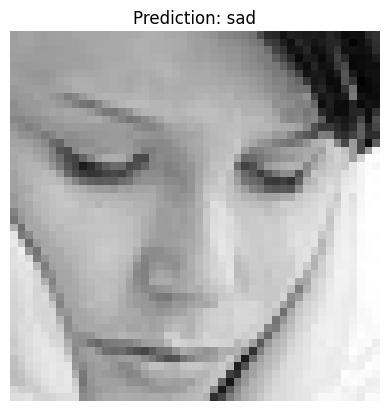


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/fear/2.jpg
Model prediction: fear (Confidence: 62.09%)


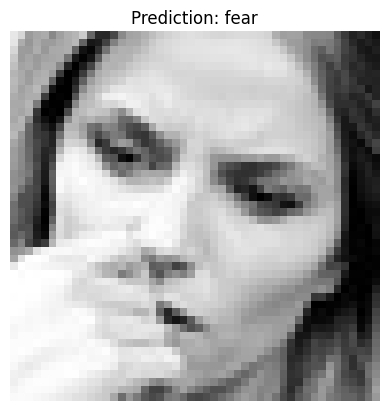


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/disgust/299.jpg
Model prediction: disgust (Confidence: 99.81%)


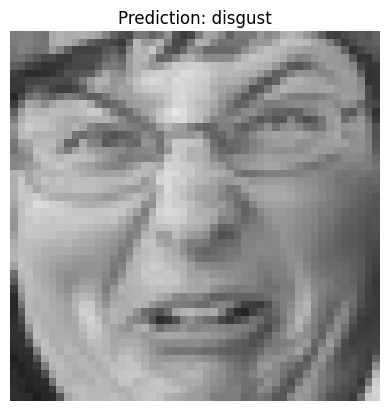


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/happy/7.jpg
Model prediction: happy (Confidence: 94.30%)


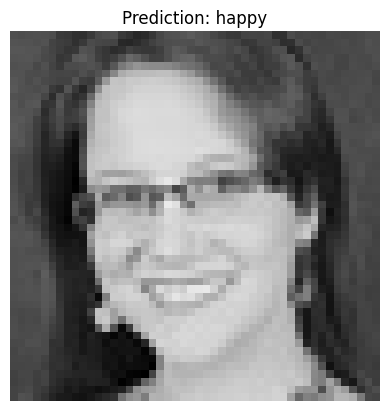


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/surprise/15.jpg
Model prediction: neutral (Confidence: 43.48%)


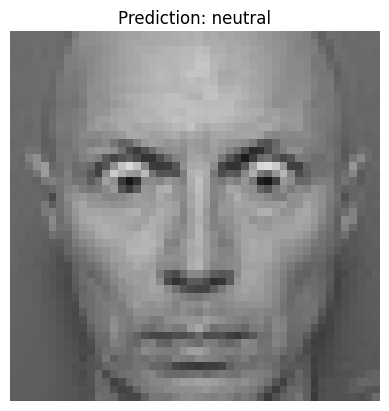


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/test/neutral/10001.jpg
Model prediction: neutral (Confidence: 41.14%)


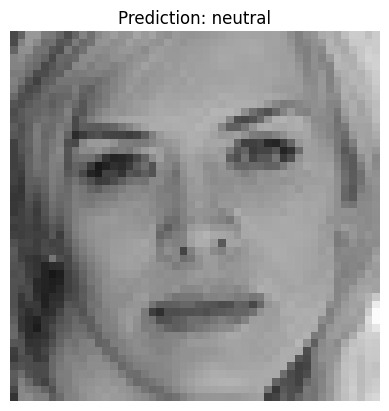

In [27]:
# --- 6. Load Best Model and Predict Single Image ---

def predict_single_image(model, image_path, classes, transform, device, model_weights_path=None):
    """
    Loads a model, predicts the class of a single image, and displays it.
    """
    # Load the model state dictionary if provided
    if model_weights_path and os.path.exists(model_weights_path):
        print(f"\nLoading best model weights from: {model_weights_path}")
        # Create a fresh model instance to load weights into
        # Need to reconstruct the model architecture exactly as it was saved
        # This part assumes you want to load the best model for inference after training
        # If 'model' is already the trained_model, you don't need to load again.
        
        # To be safe and load the *best* model saved during training:
        if isinstance(model, nn.Module): # Check if it's already a PyTorch model
            # Re-initialize the model if needed, or assume it's the correct structure
            # For this context, we'll assume `model` passed to this function is the one that was saved
            pass
        else:
            # You would reconstruct the model here, e.g.:
            # model = models.mobilenet_v3_large(weights=None) # Start with uninitialized weights
            # in_features_reconstruct = model.classifier[3].in_features
            # model.classifier[3] = nn.Linear(in_features_reconstruct, len(classes))
            # model = model.to(device)
            pass # Keep using the passed 'model' for simplicity now.
            
        model.load_state_dict(torch.load(model_weights_path, map_location=device, weights_only=True))
    
    model.eval() # Set model to evaluation mode
    
    try:
        # Load the image
        img = Image.open(image_path).convert('RGB')
        print(f"Original image from: {image_path}")

        # Apply the same transformations as the test set
        img_tensor = transform(img).unsqueeze(0).to(device) # Add batch dimension

        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = torch.softmax(output, dim=1)
            _, predicted_idx = torch.max(probabilities, 1)
            
            pred_label = classes[predicted_idx.item()]
            confidence = probabilities[0, predicted_idx.item()].item() * 100

        print(f"Model prediction: {pred_label} (Confidence: {confidence:.2f}%)")
        
        # Display the image
        plt.imshow(img)
        plt.title(f"Prediction: {pred_label}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage for single image prediction
print("\n--- Testing Single Image Prediction ---")
test_image_paths = [
    'images/train/sad/42.jpg',
    'images/train/fear/2.jpg',
    'images/train/disgust/299.jpg',
    'images/train/happy/7.jpg',
    'images/train/surprise/15.jpg',
    'images/test/neutral/10001.jpg' # Example from test set
]

for img_path in test_image_paths:
    # Use the best model saved during training for prediction
    predict_single_image(trained_model, img_path, classes, test_transform, device, 
                         model_weights_path=os.path.join(model_save_dir, "best_mobilenetv3_emotion.pth"))
    time.sleep(1)
